In [1]:
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

In [2]:
omdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True)
wiki = pd.read_json('wikidata-movies.json.gz', orient='record', lines=True)
tomatoes = pd.read_json('rotten-tomatoes.json.gz', orient='record', lines=True)

In [3]:
omdb = omdb[['imdb_id','omdb_plot']]

In [4]:
df = pd.merge(wiki, tomatoes, on='imdb_id', how='inner')

In [5]:
df = df[['imdb_id','audience_average','audience_percent','audience_ratings','critic_average','critic_percent']]

In [6]:
df = df[df['audience_ratings'] > 3000]

In [7]:
df = df.dropna(how = 'any')

In [8]:
df['overall'] = (df['audience_average']/5.0)*30 + (df['audience_percent']/100)*10 + (df['critic_average']/10.0)*40 + (df['critic_percent']/100)*20

In [9]:
df.loc[df['overall'] >= 80, "success",]= 'success'
df.loc[df['overall'] < 80, "success",]= 'no_success'

In [10]:
df = df[['imdb_id','success']]

In [11]:
df.head()

,imdb_id,success
60,tt4157220,success
61,tt0498329,no_success
63,tt2006040,no_success
66,tt0412637,no_success
67,tt1341167,no_success


In [12]:
omdb.head()

,imdb_id,omdb_plot
0,tt0060814,"In this sprawling, star-laden film, we see the..."
1,tt2379713,A cryptic message from the past sends James Bo...
2,tt0230575,"The makers of this parody of ""Night of the Liv..."
3,tt0065988,Jack Crabb is 121 years old as the film begins...
4,tt1995390,"When Perry and his girlfriend, Gail, cross pat..."


In [13]:
omdb = omdb.join(df.set_index('imdb_id'), on = 'imdb_id')

In [14]:
omdb.head()

,imdb_id,omdb_plot,success
0,tt0060814,"In this sprawling, star-laden film, we see the...",NaN
1,tt2379713,A cryptic message from the past sends James Bo...,no_success
2,tt0230575,"The makers of this parody of ""Night of the Liv...",NaN
3,tt0065988,Jack Crabb is 121 years old as the film begins...,success
4,tt1995390,"When Perry and his girlfriend, Gail, cross pat...",no_success


In [15]:
omdb = omdb.dropna(how = 'any')

In [16]:
data = omdb[['success', 'omdb_plot']]

In [17]:
data.head()

,success,omdb_plot
1,no_success,A cryptic message from the past sends James Bo...
3,success,Jack Crabb is 121 years old as the film begins...
4,no_success,"When Perry and his girlfriend, Gail, cross pat..."
5,success,"Protagonist Alex DeLarge is an ""ultraviolent"" ..."
6,no_success,Captain Jack Sparrow (Depp) crosses paths with...


### Machine Learning with Text TF-IDF 

In [18]:
cv = TfidfVectorizer(min_df=1, stop_words='english')
X = data['omdb_plot']
y = data['success']
X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv.fit_transform(X_train)
model_1 = MultinomialNB(alpha=0.1, fit_prior=False,)
model_1.fit(x_traincv, y_train)
x_testcv = cv.transform(X_test)
predict = model_1.predict(x_testcv)
actual = np.array(y_test)
print(accuracy_score(actual, predict))

0.8282747603833865


In [19]:
my_tags = ['success', 'no_success']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=0)
    plt.yticks(tick_marks, target_names)
#     plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

confusion matrix
 [[1010   48]
 [ 167   27]]
(row=True, col=predicted)


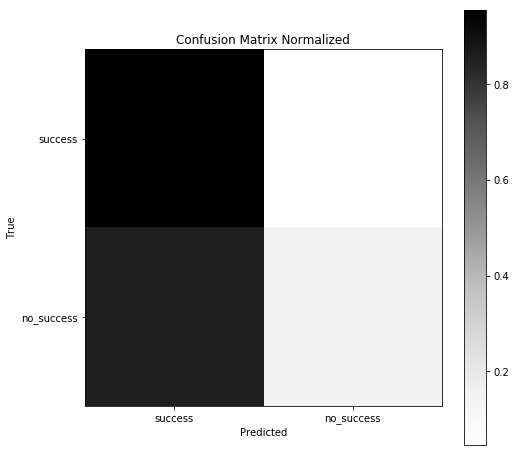

In [20]:
cm = confusion_matrix(actual, predict)
print('confusion matrix\n %s' % cm)
print('(row=True, col=predicted)')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_normalized, 'Confusion Matrix Normalized')
plt.show()

### Machine Learning with Text Count Vectorizer

In [21]:
cv1 = CountVectorizer()
X = data['omdb_plot']
y = data['success']
X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv1.fit_transform(X_train)
model_2 = MultinomialNB(alpha=0.1, fit_prior=False,)
model_2.fit(x_traincv, y_train)
x_testcv = cv1.transform(X_test)
predict2 = model_2.predict(x_testcv)
actual2 = np.array(y_test)
print(accuracy_score(actual2, predict2))

0.805111821086262


confusion matrix
 [[986  73]
 [171  22]]
(row=True, col=predicted)


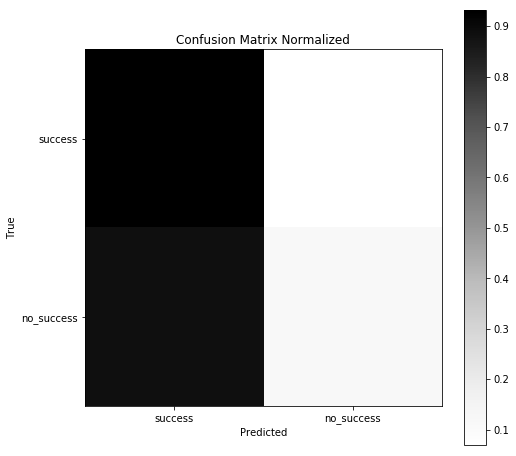

In [22]:
cm = confusion_matrix(actual2, predict2)
print('confusion matrix\n %s' % cm)
print('(row=True, col=predicted)')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_normalized, 'Confusion Matrix Normalized')
plt.show()

### Grid Searching to find the best parameters for my models

In [23]:
from sklearn.model_selection import GridSearchCV

tuning_parameters = {'alpha': [1e-2, 1e-3, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'fit_prior':[True, False]}
clf = GridSearchCV(MultinomialNB(), tuning_parameters, cv=None, n_jobs=-1, verbose=0, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv.fit_transform(X_train)
x_testcv = cv.transform(X_test)

clf.fit(x_traincv, y_train)
print("Best parameters set found on training set:")
print(clf.best_params_)
predicted_mb = clf.predict(x_testcv)
accuracy_score(y_test, predicted_mb)

Best parameters set found on training set:
{'alpha': 0.2, 'fit_prior': True}


0.8402555910543131

In [24]:
tuning_parameters = {'alpha': [1e-2, 1e-3, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'fit_prior':[True, False]}
clf = GridSearchCV(MultinomialNB(), tuning_parameters, cv=None, n_jobs=-1, verbose=0, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X, y)
x_traincv = cv1.fit_transform(X_train)
x_testcv = cv1.transform(X_test)

clf.fit(x_traincv, y_train)
print("Best parameters set found on training set:")
print(clf.best_params_)
predicted_mb = clf.predict(x_testcv)
accuracy_score(y_test, predicted_mb)

Best parameters set found on training set:
{'alpha': 1, 'fit_prior': True}


0.8538338658146964